In [5]:
using PyPlot
using JuLIP, JuLIP.ASE, JuLIP.Potentials, JuLIP.Constraints 
using ForwardDiff

function layers(at)
    dz = 1/(2*√2) * ( bulk("Si", cubic=true) |> defm )[1,1]
    X = positions(at) |> mat
    x, y, z = X[1,:], X[2,:], X[3,:] 
    I0 = find(z .<= 0.5*dz)
    I1 = find(0.5*dz .< z .<= 1.5*dz)
    I2 = find(1.5*dz .< z .<= 2.5*dz)
    I3 = find(z .> 2.5*dz)
    return [x[I0]'; y[I0]'], [x[I1]'; y[I1]'], [x[I2]'; y[I2]'], [x[I3]'; y[I3]']
end 

function plot_layers(at, x0=nothing)
    X0, X1, X2, X3 = layers(at)
    plot(X0[1,:], X0[2,:], "b.", markersize=8)
    plot(X1[1,:], X1[2,:], "g.", markersize=8)
    plot(X2[1,:], X2[2,:], "r.", markersize=8)
    plot(X3[1,:], X3[2,:], "y.", markersize=8)
    if x0 != nothing 
        plot([x0[1]], [x0[2]], "r.", markersize=10)
    end 
end


# TODO: remove?
# dists(at, x0) = [norm(x - x0) for x in positions(at)]
;

In [26]:
reload("MaterialsScienceTools")
Si = MaterialsScienceTools.Si
sw = Si.sw_eq()
;

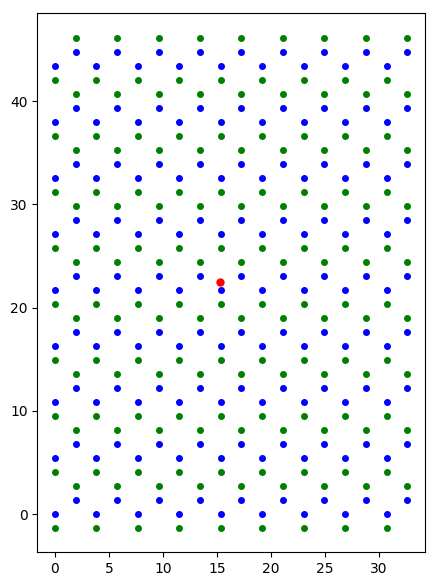

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13ff5dd50>

In [10]:
at, b, x0 = Si.si_plane(9)
figure(figsize=(5,7))
plot_layers(at, x0)

6×6 Array{Float64,2}:
  1.39632    0.477063   0.0260112  -0.0        0.0       -0.0     
  0.477063   0.945264   0.477063    0.0       -0.0       -0.0     
  0.0260112  0.477063   1.39632    -0.0        0.0        0.0     
 -0.0        0.0       -0.0         0.685153  -0.0       -0.0     
  0.0        0.0       -0.0        -0.0        0.234101   0.0     
 -0.0        0.0        0.0        -0.0       -0.0        0.685153

6×6 Array{Float64,2}:
  0.945264   0.477063   0.477063   0.0        0.0       -0.0     
  0.477063   0.945264   0.477063  -0.0       -0.0       -0.0     
  0.477063   0.477063   0.945264  -0.0       -0.0        0.0     
  0.0        0.0       -0.0        0.352384   0.0        0.0     
  0.0       -0.0       -0.0        0.0        0.352384   0.0     
 -0.0       -0.0        0.0        0.0        0.0        0.352384

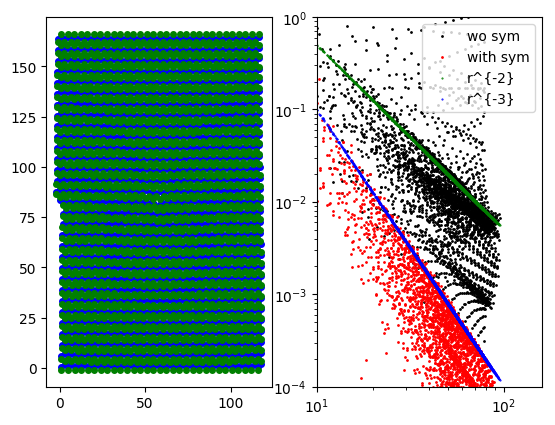

4-element Array{Float64,1}:
  10.0   
 160.0   
   0.0001
   1.0   

In [33]:
reload("MaterialsScienceTools")
Si = MaterialsScienceTools.Si 
CLE = MaterialsScienceTools.CLE
CB = MaterialsScienceTools.CauchyBorn

R = 31

# setup undeformed geometry
at, b, x0 = Si.si_plane(R)
a = cell(bulk("Si", cubic=true))[1,1]  # = 5.43

# get elastic constants
atu = Si.si_plane(1)[1]  # bulk("Si", pbc=true)
set_pbc!(atu, true)
set_calculator!(atu, sw)
Cv = CLE.voigt_moduli(atu)  # TODO: fix the elastic moduli!!!
Cv = round.(Cv, 8)

W = CB.WcbQuad()
C = CLE.elastic_moduli(W)
Cv2 = CLE.voigt_moduli(C)
Cv2 = round.(Cv2, 8)

display(Cv); println()
display(Cv2); println()

# edge solution 
U = Si.Edge.EdgeCubic(b, Cv2, a)
U.x0[:] = x0[1:2]
Si.ml_displacement!(at, U)
f = forces(sw, at)

at, _, _ = Si.si_plane(R)
Si.symml_displacement!(at, U)
fsym = forces(sw, at)

figure()
subplot(1,2,1)
plot_layers(at)

at, _, _ = Si.si_plane(R)
r0 = rnn("Si")
x, y, _ = xyz(at)
xL, xR = extrema(x); yL, yR = extrema(y)
Iint = find( (xL+2*r0 .< x .< xR - 2*r0) .* (yL+2*r0 .< y .< yR - 2*r0) )

# compute the forces
f = norm.(f)[Iint]
fsym = norm.(fsym)[Iint]
#r = dists(at, zeros(3))[Iint]
r = [ norm(x - [U.x0; 0]) for  x in positions(at)[Iint] ]
# subplot(1,2,2)
# loglog(r, fsym, "r.", markersize=2)
# loglog(r, 5*r.^(-2), "g.", r, 100*r.^(-3), "b.", markersize=1)
# legend(("with sym", "r^{-2}", "r^{-3}"))
# axis([10, 160, 3e-4, 1e-1])
subplot(1,2,2)
loglog(r, f, "k.", r, fsym, "r.", markersize=2)
loglog(r, 50*r.^(-2), "g.", r, 100*r.^(-3), "b.", markersize=1)
legend(("wo sym", "with sym", "r^{-2}", "r^{-3}"))
axis([10, 160, 1e-4, 1.0])